In [36]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(argparse))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(PGSEA))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggradar))
suppressPackageStartupMessages(library(scales))
options(bitmapType = 'cairo', device = 'png')
options(bitmapType = 'cairo', device = 'pdf')
Sys.setlocale("LC_NUMERIC", "C")


setwd('/psycl/g/mpsziller/lucia/')

functR <- 'priler_project/Software/model_clustering/clustering_functions.R'
Reactome_macro_file <- 'priler_project/refData/ReactomePathways_macro_2021.RData'
Reactome_macro_immune_file <- 'priler_project/refData/ReactomePathways_macro_Immune_2021.RData'
type_cluster <- 'Cases'
pval_feat <- 0.05
type_cluster_data <- 'tscore'
tissue_name <- 'DLPC_CMC'
pheno_name <- 'SCZ'
fold <- 'SCZ_PGC/eQTL_PROJECT/clustering_res_matchUKBB/matchUKBB_clDLPC_CMC_'
fold_out <- 'priler_project/Figure_CASTom-iGEx_paper/SCZ_part2/matchUKBB_clDLPC_CMC_'
geneInfoFile <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/resPrior_regEval_allchr.txt'
genes_to_filter <- 'compare_prediction_UKBB_SCZ-PGC/DLPC_CMC_filter_genes_matched_datasets.txt'
tscore_featRel_tot_file <- sprintf('%stscoreOriginal_tscoreClusterCases_featAssociation.txt', fold)
tscore_featRel_info_file <- sprintf('%stscoreOriginal_tscoreClusterCases_infoGenes.txt', fold)
pathGO_featRel_tot_file <- sprintf('%spath_GOOriginal_tscoreClusterCases_featAssociation.txt', fold)
pathR_featRel_info_file <- sprintf('%spath_ReactomeOriginal_tscoreClusterCases_infopath.txt', fold)
pathGO_featRel_info_file <- sprintf('%spath_GOOriginal_tscoreClusterCases_infopath.txt', fold)
pathR_featRel_tot_file <- sprintf('%spath_ReactomeOriginal_tscoreClusterCases_featAssociation.txt', fold)
pathGO_featRel_summ_file <- sprintf('%stscore_zscaled_clusterCases_summary_path_GO_tissueSpec.txt', fold)
pathR_featRel_summ_file <- sprintf('%stscore_zscaled_clusterCases_summary_path_Reactome_tissueSpec.txt', fold)
tscore_summary_file <- sprintf('%stscore_zscaled_clusterCases_summary_geneLoci_allTissues.txt', fold)
pathR_noMHC_file <- sprintf('%spath_Reactome_notMHC_grSpec.txt', fold)
pathGO_noMHC_file <- sprintf('%spath_GO_notMHC_grSpec.txt', fold)

source(functR)

tscore_feat <- read.delim(tscore_featRel_tot_file, h=T, stringsAsFactors = F, sep = '\t')
tscore_info <- read.delim(tscore_featRel_info_file, h=T, stringsAsFactors = F, sep = '\t')
tscore_feat_sign <- tscore_feat[tscore_feat$pval_corr <= 0.05, ]
tscore_summ <- read.delim(tscore_summary_file, h=T, stringsAsFactors = F, sep = '\t')
pathR_feat <- read.delim(pathR_featRel_tot_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_feat <- read.delim(pathGO_featRel_tot_file, h=T, stringsAsFactors = F, sep = '\t')
pathR_info <- read.delim(pathR_featRel_info_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_info <- read.delim(pathGO_featRel_info_file, h=T, stringsAsFactors = F, sep = '\t')
pathR_summ <- read.delim(pathR_featRel_summ_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_summ <- read.delim(pathGO_featRel_summ_file, h=T, stringsAsFactors = F, sep = '\t')
pathR_notMHC <- read.delim(pathR_noMHC_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_notMHC <- read.delim(pathGO_noMHC_file, h=T, stringsAsFactors = F, sep = '\t')

tscore_feat_tissue <- tscore_feat[tscore_feat$tissue %in% tissue_name, ]


convert_tissue_name <- function(vect_name){
  vect_name[vect_name %in% 'DLPC_CMC'] <- 'DLPC'
  vect_name[vect_name %in% 'Brain_Caudate_basal_ganglia'] <- 'BCbg'
  vect_name[vect_name %in% 'Brain_Cerebellar_Hemisphere'] <- 'BCeH'
  vect_name[vect_name %in% 'Brain_Cerebellum'] <- 'BCe'
  vect_name[vect_name %in% 'Brain_Cortex'] <- 'BC'
  vect_name[vect_name %in% 'Brain_Frontal_Cortex_BA9'] <- 'BFCB'
  vect_name[vect_name %in% 'Brain_Hippocampus'] <- 'BHi'
  vect_name[vect_name %in% 'Brain_Hypothalamus'] <- 'BHy'
  vect_name[vect_name %in% 'Brain_Nucleus_accumbens_basal_ganglia'] <- 'BNabg'
  vect_name[vect_name %in% 'Cells_EBV-transformed_lymphocytes'] <- 'CEl'  
  
  return(vect_name)
}


[1] "C"

`summarise()` ungrouping output (override with `.groups` argument)



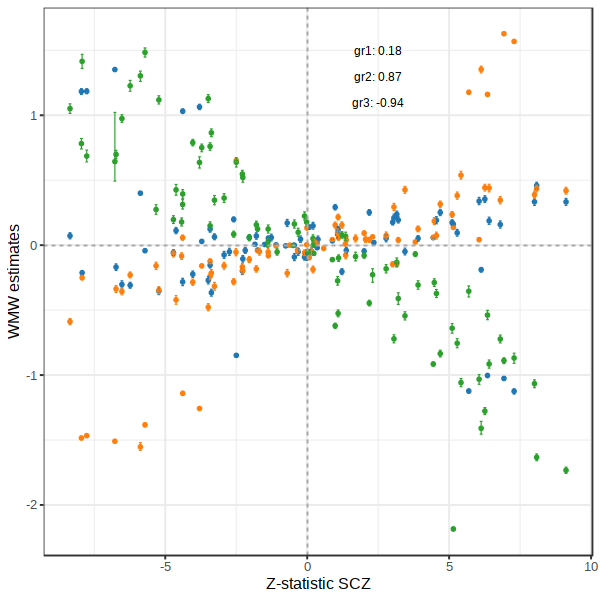

In [37]:
######################################################################
### plot Z-stat versus WMW estimates in tissue used for clustering ###
######################################################################

options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)
# remove duplicates
tmp <- tscore_info[tscore_info$tissue %in% tissue_name, ]
id_dup <- tmp$external_gene_name[duplicated(tmp$external_gene_name)]
if(length(id_dup)>0){
  tmp <- tmp[!tmp$external_gene_name %in% id_dup, ]
}
tscore_feat_tissue$Zstat <- tmp$Zstat[match(tscore_feat_tissue$feat, tmp$external_gene_name)]
tscore_feat_tissue$gr <- unname(sapply(tscore_feat_tissue$comp, function(x) strsplit(x, split = '_vs_all')[[1]]))
tscore_feat_tissue$gr <- factor(tscore_feat_tissue$gr)

# only significant
feat_red <- tscore_feat_tissue[tscore_feat_tissue$pval_corr<= pval_feat, ]
df_corr <- feat_red %>% 
  group_by(gr) %>% 
  summarise(sp_corr = cor(Zstat, estimates, method = 'spearman'), 
            sp_corr_pval = cor.test(Zstat, estimates, method = 'spearman')$p.value)
df_corr <- as.data.frame(df_corr)
df_corr$label <- paste(df_corr$gr,round(df_corr$sp_corr, digits = 2), sep = ': ')
df_corr$x <- 2.5
df_corr$y <- c(1.5, 1.3,1.1)

pl1 <-  ggplot(feat_red, aes(x = Zstat, y = estimates, color = gr, ymin = CI_low, ymax =CI_up))+
  geom_point(size = 0.8)+geom_errorbar(width = 0.1, size = 0.3)+
  ylab('WMW estimates')+xlab('Z-statistic SCZ')+
  geom_vline(xintercept = 0, linetype = 'dashed', color = 'darkgrey')+
  geom_hline(yintercept = 0, linetype = 'dashed', color = 'darkgrey')+
  # geom_smooth(method = 'lm', formula = y~x, se = T, size = 0.4)+
  # scale_color_d3()+
  #geom_text(aes(x=x, y=y, label=label, color = gr))+
  annotate("text", x = df_corr$x, y = df_corr$y, label = df_corr$label, size=3)+
  scale_color_d3()+
  theme_bw()+theme(legend.position = 'none', legend.title = element_blank())
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_compare_Zstat_est.png',fold_out,type_cluster_data,type_cluster), width = 4, height = 4, plot = pl1, device = 'png')
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_compare_Zstat_est.pdf',fold_out,type_cluster_data,type_cluster), width = 4, height = 4, plot = pl1, device = 'pdf')

# print:
pl1
                                       


[1] "significant genes in MHC across all tissues: 557 out of 687"
[1] "percentage genes in MHC across all tissues: 0.810771470160116"


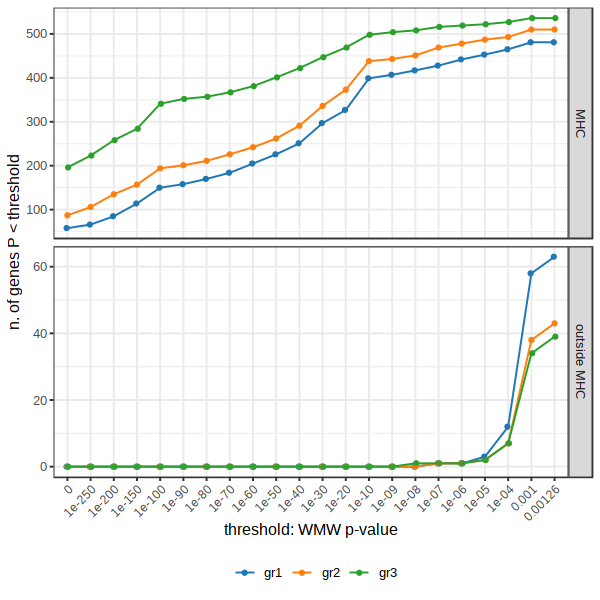

In [38]:
################################################################
### plot distribution p-values clust specific: MHC vs no MHC ###
################################################################
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res = 100)

genes_MHC <- strsplit(tscore_summ$gene[tscore_summ$loci_id == 'chr6:23.9-34.9Mb'], split = ',')[[1]]
# percentage of group-specifc genes located in MHC:
print(paste('significant genes in MHC across all tissues:', tscore_summ$ngenes_withrep[tscore_summ$loci_id == 'chr6:23.9-34.9Mb'], 'out of', sum(tscore_summ$ngenes_withrep)))
# "significant genes in MHC across all tissues: 557 out of 687"
print(paste('percentage genes in MHC across all tissues:', tscore_summ$ngenes_withrep[tscore_summ$loci_id == 'chr6:23.9-34.9Mb']/sum(tscore_summ$ngenes_withrep)))
# "percentage genes in MHC across all tissues: 0.81"
tscore_feat_sign$class <- 'outside MHC'
tscore_feat_sign$class[tscore_feat_sign$feat %in% genes_MHC] <- 'MHC'
tscore_feat_sign$class <- factor(tscore_feat_sign$class, levels = c('MHC', 'outside MHC'))
tscore_feat_sign$gr <- unname(sapply(tscore_feat_sign$comp, function(x) strsplit(x, split = '_vs_all')[[1]]))
tscore_feat_sign$gr <- factor(tscore_feat_sign$gr)
tscore_feat_sign$tr_pval <- -log10(tscore_feat_sign$pval)


# cumulative counts
pval_thr <- rev(c(seq(10, 100, by=10), seq(150, 250, by=50)))
pval_thr <- c(0, 1/10^(pval_thr), 1/10^(9:3), max(tscore_feat_sign$pval))

df_count <- list()
for(i in 1:length(pval_thr)){
  df_count[[i]] <- tscore_feat_sign %>% 
    group_by(class,gr) %>% 
    summarise(count = sum(pval<=pval_thr[i]), .groups = 'drop') %>%
    add_column(thr = pval_thr[i])
}
df_count <- bind_rows(df_count)
df_count <- as.data.frame(df_count)
df_count$thr <- factor(df_count$thr, levels = pval_thr)

pl1 <-  ggplot(df_count, aes(x = thr, y = count, color = gr, group = gr))+
  geom_point(position = position_dodge(width = 0.1), size=1)+
  geom_line()+
  facet_wrap(class~., scales = 'free_y',ncol =  1, strip.position="right")+
  ylab('n. of genes P < threshold')+
  xlab('threshold: WMW p-value')+
  # scale_fill_d3()+
  scale_color_d3()+
  theme_bw()+theme(legend.position = 'bottom', legend.title = element_blank(), 
                   axis.text.x = element_text(angle = 45, hjust = 1, size = 8))
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_compareDist_MHC_noMHC.png',fold_out,type_cluster_data,type_cluster), width = 4, height = 4, plot = pl1, device = 'png')
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_compareDist_MHC_noMHC.pdf',fold_out,type_cluster_data,type_cluster), width = 4, height = 4, plot = pl1, device = 'pdf')

# print
pl1

In [39]:
#################################################
### cliclize plot: MHC versus not MHC (count) ###
#################################################

class_genes <- c('MHC', 'outside MHC')
tscore_feat_sign$feat_tissue <- paste0(tscore_feat_sign$feat,'_',tscore_feat_sign$tissue)
df_class <- data.frame(class = class_genes, count = sapply(class_genes, function(x) length(unique(tscore_feat_sign$feat_tissue[tscore_feat_sign$class == x]))))
df_class$fraction <- df_class$count / sum(df_class$count)
df_class$ymax <- cumsum(df_class$fraction)
df_class$ymin <- c(0, head(df_class$ymax, n=-1))
df_class$labelPosition <- (df_class$ymax + df_class$ymin) / 2
# Compute a good label
df_class$label <- paste0(df_class$class, '\n', df_class$count, ' genes')
df_class
                                                           
tscore_feat_sign_new <- tscore_feat_sign
tscore_feat_sign$comp <- unname(sapply(tscore_feat_sign_new$comp, function(x) strsplit(x, split = '_vs_all')[[1]][1]))
tscore_feat_sign_new <- tscore_feat_sign_new[!duplicated(tscore_feat_sign_new$feat_tissue), ]
tscore_feat_sign_new$comp_multiple <- NA
for(i in 1:nrow(tscore_feat_sign_new)){

    tmp <- tscore_feat_sign$comp[tscore_feat_sign$feat_tissue == tscore_feat_sign_new$feat_tissue[i]]
    tscore_feat_sign_new$comp_multiple[i] <- paste0(tmp, collapse = ',')
}
df_class_gr <- tscore_feat_sign_new %>% 
    group_by(class,comp_multiple) %>% 
    summarise(count = n(), .groups = 'drop') 
df_class_gr <- as.data.frame(df_class_gr)
df_class_gr$fraction <- df_class_gr$count / sum(df_class_gr$count)
df_class_gr                                       
df_class_gr_plot <- data.frame(gr = rep(sort(unique(tscore_feat_sign$comp)), 2), 
                               class = unlist(lapply(class_genes, function(x) rep(x, length(unique(tscore_feat_sign$comp))))))

# specifically for 3 groups
# gr1
max1 <- sum(df_class_gr$fraction[grepl('gr1',df_class_gr$comp_multiple) & df_class_gr$class == 'MHC'])
max2 <- sum(df_class_gr$fraction[grepl('gr1',df_class_gr$comp_multiple) & df_class_gr$class == 'outside MHC'])
df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr1'] <- df_class$ymin
df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr1'] <- c(max1, df_class$ymin[df_class$class == 'outside MHC'] + max2)          

# gr2
df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr2'] <- df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr1'] - 
                         sapply(class_genes, function(x) sum(df_class_gr$fraction[grepl('gr1,gr2',df_class_gr$comp_multiple) & df_class_gr$class == x]))                
max1 <- sum(df_class_gr$fraction[grepl('gr2',df_class_gr$comp_multiple) & df_class_gr$class == 'MHC'])
max2 <- sum(df_class_gr$fraction[grepl('gr2',df_class_gr$comp_multiple) & df_class_gr$class == 'outside MHC'])
df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr2'] <- c(max1, max2) + df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr2']

# gr3
for(i in class_genes){
    tmp <- df_class_gr[grepl('gr3',df_class_gr$comp_multiple) & df_class_gr$class == i,]
    if('gr1,gr2,gr3' %in% tmp$comp_multiple & 'gr1,gr3' %in% tmp$comp_multiple){
        # start
        new_value <- df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr2' & df_class_gr_plot$class == i] - sum(df_class_gr$fraction[grepl('gr1,gr3',df_class_gr$comp_multiple) & df_class_gr$class == i])
        df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr3' & df_class_gr_plot$class == i] <- new_value
        # end
        new_value <- df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr2' & df_class_gr_plot$class == i] + sum(df_class_gr$fraction[grepl('gr1,gr2,gr3',df_class_gr$comp_multiple) & df_class_gr$class == i])
        df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr3' & df_class_gr_plot$class == i] <- new_value
    }
    if((!'gr1,gr2,gr3' %in% tmp$comp_multiple) & 'gr1,gr3' %in% tmp$comp_multiple){
        # start
        new_value <- df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr1' & df_class_gr_plot$class == i]
        df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr3' & df_class_gr_plot$class == i] <- new_value
        # end
        new_value <- df_class_gr_plot$ymin[df_class_gr_plot$gr == 'gr1' & df_class_gr_plot$class == i] + sum(df_class_gr$fraction[grepl('gr1,gr3',df_class_gr$comp_multiple) & df_class_gr$class == i])
        df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr3' & df_class_gr_plot$class == i] <- new_value
    }
    if('gr2,gr3' %in% tmp$comp_multiple){
        new_row <- data.frame(gr = 'gr3', class = i)
        # start
        new_value <- df_class_gr_plot$ymax[df_class_gr_plot$gr == 'gr2' & df_class_gr_plot$class == i] - df_class_gr$fraction[df_class_gr$comp_multiple == 'gr2,gr3' & df_class_gr$class == i]
        new_row$ymin <- new_value
        # end
        new_value <- df_class$ymax[df_class$class == i] 
        new_row$ymax <- new_value
        df_class_gr_plot <- rbind(df_class_gr_plot, new_row)
   }
        
}
df_class_gr_plot

# save
write.table(file = sprintf('%stscoreOriginal_%sCluster%s_perc_MHC_noMHC.txt',fold_out,type_cluster_data,type_cluster), 
           x = df_class_gr, col.names = T,row.names = F, sep = '\t', quote = F)

,class,count,fraction,ymax,ymin,labelPosition,label
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
MHC,MHC,557,0.8107715,0.8107715,0.0000000,0.4053857,MHC 557 genes
outside MHC,outside MHC,130,0.1892285,1.0000000,0.8107715,0.9053857,outside MHC 130 genes


class,comp_multiple,count,fraction
<fct>,<chr>,<int>,<dbl>
MHC,gr1,1,0.001455604
MHC,"gr1,gr2",17,0.024745269
MHC,"gr1,gr2,gr3",430,0.625909753
MHC,"gr1,gr3",33,0.048034934
MHC,gr2,3,0.004366812
MHC,"gr2,gr3",60,0.087336245
MHC,gr3,13,0.018922853
outside MHC,gr1,49,0.071324600
outside MHC,"gr1,gr2",9,0.013100437


gr,class,ymin,ymax
<chr>,<chr>,<dbl>,<dbl>
gr1,MHC,0.000000000,0.7001456
gr2,MHC,0.049490539,0.7918486
gr3,MHC,0.001455604,0.6754003
gr1,outside MHC,0.810771470,0.9024745
gr2,outside MHC,0.889374090,0.9519651
gr3,outside MHC,0.810771470,0.8180495
gr3,MHC,0.704512373,0.8107715
gr3,outside MHC,0.950509461,1.0000000


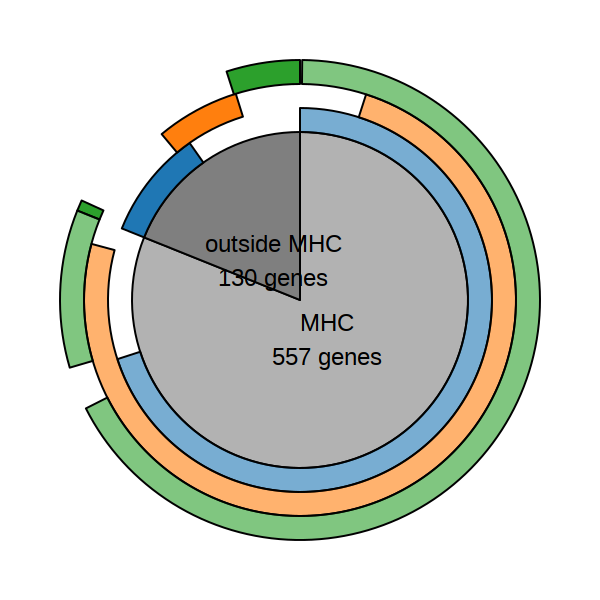

In [40]:
colors_gr <- pal_d3(palette = 'category20')(3)

pl <- ggplot(df_class, aes(ymax=ymax, ymin=ymin, xmax=6, xmin=-1, alpha=class)) +
  geom_rect(color = 'black', fill = 'grey50') +
  geom_rect(data = subset(df_class_gr_plot, gr == 'gr1'), mapping = aes(ymax=ymax, ymin=ymin, xmax=7, xmin=6, alpha=class), 
              fill = colors_gr[1], color = 'black',
              inherit.aes = FALSE) +
  geom_rect(data = subset(df_class_gr_plot, gr == 'gr2'), mapping = aes(ymax=ymax, ymin=ymin, xmax=8, xmin=7, alpha=class), 
              fill = colors_gr[2], color = 'black',
              inherit.aes = FALSE) +
  geom_rect(data = subset(df_class_gr_plot, gr == 'gr3'), mapping = aes(ymax=ymax, ymin=ymin, xmax=9, xmin=8, alpha=class), 
              fill = colors_gr[3], color = 'black',
              inherit.aes = FALSE) +
  geom_text(x = 1, aes(y=labelPosition, label=label), color = 'black', size=6, alpha = 1) + # x here controls label position (inner / outer)
  scale_alpha_manual(values = c(0.6, 1)) +
  coord_polar(theta="y") +
  xlim(c(-1, 9)) +
  theme_void() +
  theme(legend.position = "none")
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_overlapSignGenes.png',fold_out,type_cluster_data,type_cluster), width = 5, height = 5, plot = pl, device = 'png')
ggsave(filename = sprintf('%stscoreOriginal_%sCluster%s_overlapSignGenes.pdf',fold_out,type_cluster_data,type_cluster), width = 5, height = 5, plot = pl, device = 'pdf')

# print 
pl


In [41]:
##################################################
### n. genes, loci, pathway and macro category ###
##################################################

## from plot_cluster_featAssociation_summary_run.R, bash: PriLer_cluster_tscore_featureRel_GTEx_SCZ_summary.sh


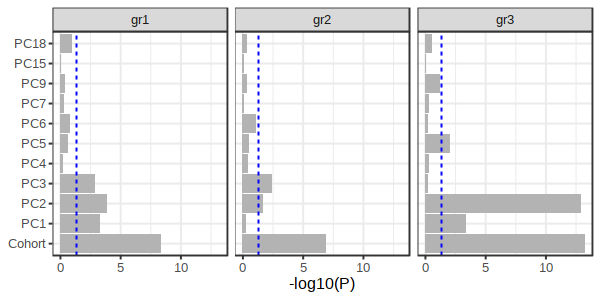

In [42]:
########################################
### p-value meta analysis covariates ###
########################################

options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 100)

# in order to perform a meta analysis for PCs, couldn't use kruskal test:
# 1) PCs rescaled in each cohort (m=0, sd=1)
# 2) lm to test gr1 vs all not gr1 --> equivalent to t.test
# 3) meta analysis from fixed effect (same as gene and endophenotype)
# for cohort: gr1 vs all not gr1 via chisquared test  


cov_test <- fread(sprintf('%stscore_zscaled_clusterCases_PGmethod_HKmetric_covTest_metaAnalysis.txt', fold), h=T, data.table = F)
cohort_test <- fread(sprintf('%stscore_zscaled_clusterCases_PGmethod_HKmetric_cohortTest.txt', fold), h=T, data.table = F)

cov_test$cov_id  <- paste0('P',cov_test$cov_id)
df <- data.frame(feat = cov_test$cov_id, comp = cov_test$comp, pval_tr = -log10(cov_test$pvalue), stringsAsFactors = F)
df <- rbind(df, data.frame(feat = rep('Cohort',nrow(cohort_test)),comp = cohort_test$comp, pval_tr = -log10(cohort_test$pvalue), stringsAsFactors = F ))
df$gr <- unname(sapply(df$comp, function(x) strsplit(x, split = '_vs_all')[[1]][1]))
df$gr <- factor(df$gr)
df$feat <- factor(df$feat, levels = c('Cohort', unique(cov_test$cov_id)))
                
pl <- ggplot(df, aes(x=feat, y=pval_tr)) +
  geom_bar(stat = 'identity', fill = 'grey70')+
  geom_hline(yintercept = -log10(0.05), linetype = 'dashed', color = 'blue')+
  facet_wrap(.~gr, nrow = 1)+
  theme_bw()+
  ylab('-log10(P)')+
  theme(legend.position = "none", axis.title.y = element_blank())+
  coord_flip()
                       
ggsave(filename = sprintf('%s%sCluster%s_covariatesPvalue.png',fold_out,type_cluster_data,type_cluster), width = 6, height = 4, plot = pl, device = 'png')
ggsave(filename = sprintf('%s%sCluster%s_covariatesPvalue.pdf',fold_out,type_cluster_data,type_cluster), width = 6, height = 4, plot = pl, device = 'pdf')

#print
pl


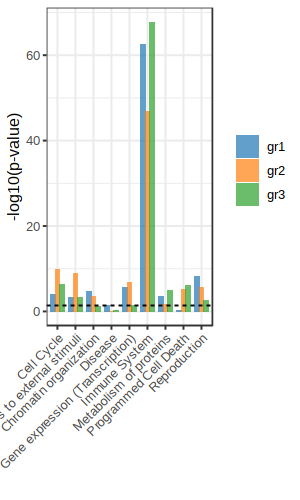

In [44]:
######################################
### enrichment class from Reactome ###
######################################

options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 100)

macroR <- get(load(Reactome_macro_file))
class_macro <- sapply(macroR, function(x) x[[1]]$V2)
                      
# annotate feature data with macro category
pathR_feat_ann <- pathR_feat
pathR_feat_ann$macro <- NA
tot_path <- unique(pathR_feat$feat)
ann_macro <- list()
for(i in 1:length(tot_path)){
  # print(i)
  ann_macro[[i]] <- class_macro[sapply(macroR, function(x) tot_path[i] %in% x$subclasses$V2)]
  pathR_feat_ann$macro[pathR_feat_ann$feat %in% tot_path[i]] <- paste0(ann_macro[[i]], collapse = ',')
}

# plot enrichment for classes
gr <- unique(pathR_feat_ann$comp)
gr <- sapply(gr, function(x) strsplit(x, split = '_vs_all')[[1]])
df_enrich <- list()
for(p in 1:length(gr)){
  #print(gr[p])
  id_sign <- pathR_feat_ann$pval_corr[pathR_feat_ann$comp %in% names(gr[p])] <= pval_feat # are the pathways significant?
  df_enrich[[p]] <- data.frame(macro = class_macro, gr = unname(gr[p]), 
                               n = NA, OR = NA, fisher_pvalue = NA)
  list_class <- lapply(pathR_feat_ann$macro[pathR_feat_ann$comp %in% names(gr[p])], function(x) strsplit(x, split = ',')[[1]])
  for(i in 1:length(class_macro)){
    #print(class_macro[i])
    id_class <- sapply(list_class, function(x) class_macro[i] %in% x) # do the pathway belong to class i?
    tmp <- fisher.test(table(id_sign, id_class), alternative = 'greater') # fisher test between significant and pathways in the class
    df_enrich[[p]]$OR[i] <- tmp$estimate
    df_enrich[[p]]$fisher_pvalue[i] <- tmp$p.value
    df_enrich[[p]]$n[i] <- sum(id_sign & id_class)
  }
}
df_enrich <- do.call(rbind, df_enrich)
df_enrich$gr <- factor(df_enrich$gr, levels = (gr)) 
df_enrich$macro <- factor(df_enrich$macro, levels = (class_macro)) 
df_enrich$pval_tr <- -log10(df_enrich$fisher_pvalue)
colors_gr <- pal_d3(palette = 'category20')(length(gr))
                       
# df_enrich
# plot
class_zero <- lapply(gr, function(x) df_enrich$macro[df_enrich$fisher_pvalue >= 0.1 & df_enrich$gr == x])
class_zero <- names(which(table(unlist(class_zero)) == length(gr)))  

# from the plot remove class with zero counts
pl <-  ggplot(subset(df_enrich, !macro %in% class_zero), aes(x = macro, y = pval_tr, fill = gr, group = gr))+
  geom_bar(width=0.8, alpha = 0.7, stat = 'identity', position = position_dodge())+
  ylab('-log10(p-value)')+
  geom_hline(yintercept = -log10(0.05), color = 'black', linetype = 'dashed')+
  scale_fill_manual(values = colors_gr)+
  # scale_color_d3()+
  theme_bw()+theme(legend.position = 'right', legend.title = element_blank(), 
                   axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1))
                     
ggsave(filename = sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro.png',fold_out,type_cluster_data,type_cluster), width = 3, height =5, plot = pl, device = 'png')
ggsave(filename = sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro.pdf',fold_out,type_cluster_data,type_cluster), width = 3, height =5, plot = pl, device = 'pdf')                        
write.table(file= sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro.txt',fold_out,type_cluster_data,type_cluster), x = df_enrich, col.names = T, row.names = F, sep = '\t', quote = F)


# print 
pl


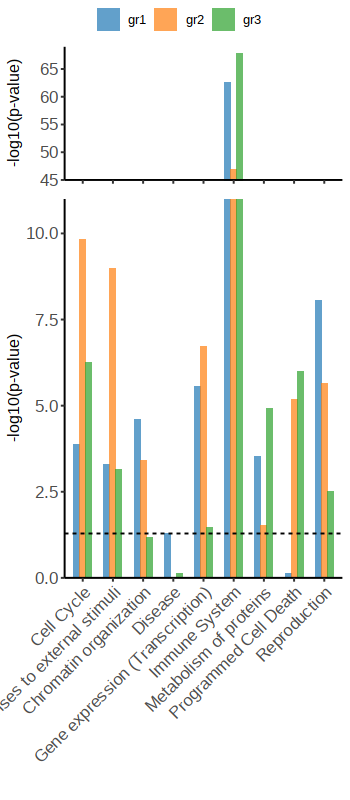

In [45]:
options(repr.plot.width = 3.5, repr.plot.height = 8, repr.plot.res = 100)

# split plot for publication
pl1 <-  ggplot(subset(df_enrich, !macro %in% class_zero), aes(x = macro, y = pval_tr, fill = gr, group = gr))+
  geom_bar(width=0.6, alpha = 0.7, stat = 'identity', position = position_dodge())+
  ylab('-log10(p-value)')+
  geom_hline(yintercept = -log10(0.05), color = 'black', linetype = 'dashed')+
  scale_fill_manual(values = (colors_gr))+
  # scale_color_d3()+
  theme_classic()+theme(legend.position = 'right', legend.title = element_blank(), 
                        axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1), 
                        axis.text = element_text(size = 12))+
  coord_cartesian( ylim = c(0, 11))+
  scale_y_continuous(expand = c(0, 0))

pl2 <-  ggplot(subset(df_enrich, !macro %in% class_zero), aes(x = macro, y = pval_tr, fill = gr, group = gr))+
  geom_bar(width=0.6, alpha = 0.7, stat = 'identity', position = position_dodge())+
  ylab('-log10(p-value)')+
  geom_hline(yintercept = -log10(0.05), color = 'black', linetype = 'dashed')+
  scale_fill_manual(values = (colors_gr))+
  # scale_color_d3()+
  theme_classic()+theme(legend.position = 'right', legend.title = element_blank(), 
                        axis.title.x = element_blank(), axis.text.x = element_blank(), 
                       axis.text = element_text(size = 12))+
  coord_cartesian(ylim = c(45, round(max(df_enrich$pval_tr)) + 1))+
  scale_y_continuous(expand = c(0, 0))

tot_pl <- ggarrange(plotlist = list(pl2, pl1), ncol = 1, nrow = 2, align='v', heights = c(1, 4), common.legend = T)
ggsave(filename = sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro_pub.png',fold_out,type_cluster_data,type_cluster), width = 3.5, height = 8, plot = tot_pl, device = 'png')
ggsave(filename = sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro_pub.pdf',fold_out,type_cluster_data,type_cluster), width = 3.5, height = 8, plot = tot_pl, dpi = 300, device = 'pdf')

# print
tot_pl


gr1_vs_all 
     "gr1" 
gr2_vs_all 
     "gr2" 
gr3_vs_all 
     "gr3" 


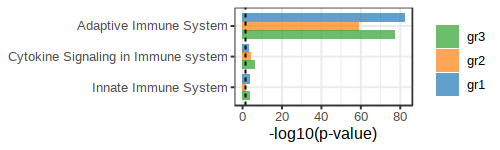

In [46]:
options(repr.plot.width = 5, repr.plot.height = 1.5, repr.plot.res = 100)

# specific for immune system:
macroR_immune <- get(load(Reactome_macro_immune_file))
pathR_feat_ann_immune <- pathR_feat_ann
pathR_feat_ann_immune$sub_macro <- 'Other'
class_macro_immune <- sapply(macroR_immune, function(x) x[[1]]$V2)
tot_path <- unique(pathR_feat_ann_immune$feat[pathR_feat_ann_immune$macro == 'Immune System'])
ann_macro <- list()
for(i in 1:length(tot_path)){
  # print(i)
  ann_macro[[i]] <- class_macro_immune[sapply(macroR_immune, function(x) tot_path[i] %in% x$subclasses$V2)]
  pathR_feat_ann_immune$sub_macro[pathR_feat_ann_immune$feat %in% tot_path[i]] <- paste0(ann_macro[[i]], collapse = ',')
}
#pathR_feat_ann_immune <- pathR_feat_ann_immune[pathR_feat_ann_immune$feat != 'Immune System',]
pathR_feat_ann_immune$sub_macro[pathR_feat_ann_immune$feat == 'Immune System'] <- 'Other'

df_enrich_immune <- list()
for(p in 1:length(gr)){
  print(gr[p])
  df_enrich_immune[[p]] <- data.frame(macro = class_macro_immune, gr = unname(gr[p]), 
                                      n = NA, OR = NA, fisher_pvalue = NA)
  list_class <- lapply(pathR_feat_ann_immune$sub_macro[pathR_feat_ann_immune$comp %in% names(gr[p])], function(x) strsplit(x, split = ',')[[1]])
  for(i in 1:length(class_macro_immune)){
    #print(class_macro[i])
    id_sign <- pathR_feat_ann_immune$pval_corr[pathR_feat_ann_immune$comp %in% names(gr[p])] <= 0.05 
    id_class <- sapply(list_class, function(x) class_macro_immune[i] %in% x)
    tmp <- fisher.test(table(id_sign, id_class), alternative = 'greater')
    df_enrich_immune[[p]]$OR[i] <- tmp$estimate
    df_enrich_immune[[p]]$fisher_pvalue[i] <- tmp$p.value
    df_enrich_immune[[p]]$n[i] <- sum(id_sign & id_class)
  }
}
df_enrich_immune <- do.call(rbind, df_enrich_immune)
# plot
df_enrich_immune$gr <- factor(df_enrich_immune$gr, levels = rev(gr)) 
df_enrich_immune$macro <- factor(df_enrich_immune$macro, levels = rev(class_macro_immune)) 
df_enrich_immune$pval_tr <- -log10(df_enrich_immune$fisher_pvalue)
colors_gr <- pal_d3(palette = 'category20')(length(gr))

pl <-  ggplot(df_enrich_immune, 
              aes(x = macro, y = pval_tr, fill = gr, group = gr))+
  geom_bar(width=0.8, alpha = 0.7, stat = 'identity', position = position_dodge())+
  ylab('-log10(p-value)')+
  geom_hline(yintercept = -log10(0.05), color = 'black', linetype = 'dashed')+
  scale_fill_manual(values = rev(colors_gr))+
  # scale_color_d3()+
  theme_bw()+theme(legend.position = 'right', legend.title = element_blank(), 
                   axis.title.y = element_blank())+
  coord_flip()
ggsave(filename = sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro_.png',fold_out,type_cluster_data,type_cluster), width = 5, height = 1.5, plot = pl, device = 'png')
ggsave(filename = sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro_Immune.pdf',fold_out,type_cluster_data,type_cluster), width = 5, height = 1.5, plot = pl, device = 'pdf')
write.table(file= sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro_Immune.txt',fold_out,type_cluster_data,type_cluster), x = df_enrich_immune, col.names = T, row.names = F, sep = '\t', quote = F)

# print 
pl

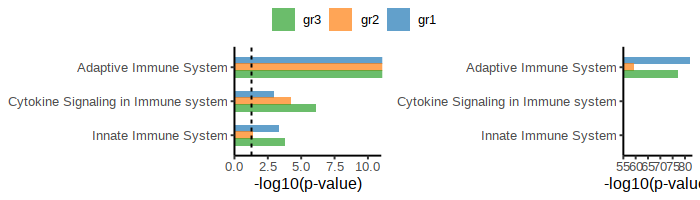

In [54]:
options(repr.plot.width = 7, repr.plot.height = 2, repr.plot.res = 100)

# split plot for publication
pl1 <-  ggplot(df_enrich_immune, aes(x = macro, y = pval_tr, fill = gr, group = gr))+
  geom_bar(width=0.6, alpha = 0.7, stat = 'identity', position = position_dodge())+
  ylab('-log10(p-value)')+
  geom_hline(yintercept = -log10(0.05), color = 'black', linetype = 'dashed')+
  scale_fill_manual(values = rev(colors_gr))+
  # scale_color_d3()+
  theme_classic()+theme(legend.position = 'right', legend.title = element_blank(), 
                        axis.title.y = element_blank())+
  coord_flip(ylim = c(0, 11))+
  scale_y_continuous(expand = c(0, 0))

pl2 <-  ggplot(df_enrich_immune, aes(x = macro, y = pval_tr, fill = gr, group = gr))+
  geom_bar(width=0.6, alpha = 0.7, stat = 'identity', position = position_dodge())+
  ylab('-log10(p-value)')+
  geom_hline(yintercept = -log10(0.05), color = 'black', linetype = 'dashed')+
  scale_fill_manual(values = rev(colors_gr))+
  # scale_color_d3()+
  theme_classic()+theme(legend.position = 'right', legend.title = element_blank(), 
                        axis.title.y = element_blank())+
  coord_flip(ylim = c(55, round(max(df_enrich_immune$pval_tr)) + 1))+
  scale_y_continuous(expand = c(0, 0))

tot_pl <- ggarrange(plotlist = list(pl1, pl2), ncol = 2, nrow = 1, align='h', widths = c(1, 0.8), common.legend = T)
ggsave(filename = sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro_Immune_pub.png',fold_out,type_cluster_data,type_cluster), width = 7, height = 2, plot = tot_pl, device = 'png')
ggsave(filename = sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro_Immune_pub.pdf',fold_out,type_cluster_data,type_cluster), width = 7, height = 2, plot = tot_pl, device = 'pdf')

# print 
tot_pl

In [116]:
#########################################################
### WMW estimates for pathways outside MHC: selection ###
#########################################################

# plot distribution pvalues for not MHC pathways
pathR_feat_ann$new_id = paste(pathR_feat_ann$feat, pathR_feat_ann$tissue, sep = '_tissue_')
pathGO_feat$new_id = paste(pathGO_feat$feat, pathGO_feat$tissue, sep = '_tissue_')
pathR_notMHC$new_id = paste(pathR_notMHC$path, pathR_notMHC$tissue, sep = '_tissue_')
pathGO_notMHC$new_id = paste(pathGO_notMHC$path, pathGO_notMHC$tissue, sep = '_tissue_')

# annotate
pathR_feat_ann$genes_in_MHClocus <- T
pathR_feat_ann$genes_in_MHClocus[pathR_feat_ann$new_id %in% pathR_notMHC$new_id] <- F
pathGO_feat$genes_in_MHClocus <- T
pathGO_feat$genes_in_MHClocus[pathGO_feat$new_id %in% pathGO_notMHC$new_id] <- F
pathR_feat_sign <- pathR_feat_ann[pathR_feat_ann$pval_corr <= 0.05, ]
n <- length(unique(pathR_feat_sign$new_id[!pathR_feat_sign$genes_in_MHClocus])) # 123
paste("n. of Reactome pathways signficant with no genes in MHC:" , n)
pathGO_feat_sign <- pathGO_feat[pathGO_feat$pval_corr <= 0.05, ]
n <- length(unique(pathGO_feat_sign$new_id[!pathGO_feat_sign$genes_in_MHClocus])) # 241
paste("n. of GO pathways signficant with no genes in MHC:" , n)

# save enrichment specific for paths not due to MHC
df_enrich_notMHC <- list()
for(p in 1:length(gr)){
  # print(gr[p])
  df_enrich_notMHC[[p]] <- data.frame(macro = class_macro, gr = unname(gr[p]), 
                                      n = NA, OR = NA, fisher_pvalue = NA)
  list_class <- lapply(pathR_feat_ann$macro[pathR_feat_ann$comp %in% names(gr[p]) & !pathR_feat_ann$genes_in_MHClocus], function(x) strsplit(x, split = ',')[[1]])
  for(i in 1:length(class_macro)){
    #print(class_macro[i])
    id_sign <- pathR_feat_ann$pval_corr[pathR_feat_ann$comp %in% names(gr[p])  & !pathR_feat_ann$genes_in_MHClocus] <= 0.05 
    id_class <- sapply(list_class, function(x) class_macro[i] %in% x)
    if(any(id_class)){
      tmp <- fisher.test(table(id_sign, id_class), alternative = 'greater')
      df_enrich_notMHC[[p]]$OR[i] <- tmp$estimate
      df_enrich_notMHC[[p]]$fisher_pvalue[i] <- tmp$p.value
    }
    df_enrich_notMHC[[p]]$n[i] <- sum(id_sign & id_class)
  }
}
df_enrich_notMHC <- do.call(rbind, df_enrich_notMHC)
df_enrich_notMHC[order(df_enrich_notMHC$fisher_pvalue)[1:10], ]
write.table(file= sprintf('%spath_ReactomeOriginal_%sCluster%s_enrichMacro_noMHC.txt',fold_out,type_cluster_data,type_cluster), x = df_enrich_notMHC, col.names = T, row.names = F, sep = '\t', quote = F)

                       

[1] "n. of Reactome pathways signficant with no genes in MHC: 123"

[1] "n. of GO pathways signficant with no genes in MHC: 241"

,macro,gr,n,OR,fisher_pvalue
,<chr>,<chr>,<int>,<dbl>,<dbl>
16,Metabolism,gr1,13,3.172120,0.009793471
71,Immune System,gr3,7,Inf,0.025336993
46,Metabolism of proteins,gr2,5,4.074342,0.040364046
31,Cell-Cell communication,gr2,2,Inf,0.046781287
45,Metabolism of RNA,gr2,2,Inf,0.046781287
9,Developmental Biology,gr1,2,6.749836,0.138186048
41,Gene expression (Transcription),gr2,4,2.194433,0.198173961
58,Cell Cycle,gr3,3,Inf,0.214208531
63,DNA Repair,gr3,3,Inf,0.214208531


In [127]:
# filter based on selection, merge tissue and reorder

keep_path <- read.delim(sprintf('%stscore_zscaled_clusterCases_keepPaths_plot.csv', fold), h=T, stringsAsFactors = F, sep = ',')
path_feat_sign <- rbind(pathGO_feat_sign[pathGO_feat_sign$feat %in% keep_path$path[keep_path$type == 'GO'], ], 
                        pathR_feat_sign[pathR_feat_sign$feat %in% keep_path$path[keep_path$type == 'Reactome'], !colnames(pathR_feat_sign) %in% 'macro'])

path_feat_tot <- rbind(pathGO_feat[pathGO_feat$feat %in% keep_path$path[keep_path$type == 'GO'], ], 
                       pathR_feat_ann[pathR_feat_ann$feat %in% keep_path$path[keep_path$type == 'Reactome'], !colnames(pathR_feat_ann) %in% 'macro'])

# exclude tissues with pathways
path_feat_tot <- path_feat_tot
path_info_tot <- rbind(pathR_info, pathGO_info[, match(colnames(pathR_info), colnames(pathGO_info))])
path_info_tot$new_id <- paste0(path_info_tot$path,'_tissue_' ,path_info_tot$tissue)
path_info_tot <- path_info_tot[path_info_tot$new_id %in% unique(path_feat_tot$new_id),]
path_info_tot$impr <- F
tmp <- list()
comp <- sort(unique(path_feat_tot$comp))
path_info_tot$impr <- F 
for(i in 1:nrow(path_info_tot)){
  # print(i)
  tmp <- path_info_tot[i, ]
  gene_names <- strsplit(tmp$genes_id, split = '[,]')[[1]]
  gene_new <- tscore_feat[tscore_feat$feat %in% gene_names & tscore_feat$tissue == tmp$tissue, ]
  comp_sign <- path_feat_tot$comp[path_feat_tot$new_id == tmp$new_id &path_feat_tot$pval_corr <= 0.05 ]
  path_info_tot$impr[i] <- any(sapply(comp_sign, function(x) all(gene_new$pval[gene_new$comp == x] > path_feat_tot$pval[path_feat_tot$new_id == tmp$new_id & path_feat_tot$comp == x])))
}

path_info_tot$database <- 'Reactome'
path_info_tot$database[path_info_tot$path %in% pathGO_info$path] <- 'Gene Ontology'
# focus only on genes that are outside MCH
path_feat_noMHC <- path_feat_tot[!path_feat_tot$genes_in_MHClocus, ]

df_tissue <- data.frame(tissue = unique(path_feat_tot$tissue))
df_tissue$short <- convert_tissue_name(df_tissue$tissue)
path_info_tot$new_id <- paste0(path_info_tot$path, ' (', df_tissue$short[match(path_info_tot$tissue, df_tissue$tissue)], ')')
path_feat_noMHC$new_id <- paste0(path_feat_noMHC$feat, ' (', df_tissue$short[match(path_feat_noMHC$tissue, df_tissue$tissue)], ')')
path_feat_noMHC$database <- 'Reactome'
path_feat_noMHC$database[path_feat_noMHC$feat %in% pathGO_info$path] <- 'Gene Ontology'
path_feat_noMHC <- path_feat_noMHC[path_feat_noMHC$new_id %in% path_info_tot$new_id, ]
path_info_noMHC <- path_info_tot[path_info_tot$new_id %in% path_feat_noMHC$new_id, ]
keep_new <- unique(path_feat_noMHC$new_id[path_feat_noMHC$pval <= 0.005 & path_feat_noMHC$pval_corr <= 0.05])
path_feat_noMHC <- path_feat_noMHC[path_feat_noMHC$new_id %in% keep_new, ]
path_info_noMHC <- path_info_noMHC[path_info_noMHC$new_id %in% keep_new, ]

path_info_noMHC$new_id_v2 <- path_info_noMHC$new_id
path_feat_noMHC$new_id_v2 <- path_feat_noMHC$new_id
merge_path <- intersect(keep_path$path, path_info_noMHC$path)

for(i in 1:length(merge_path)){
  
  #print(i)
  tmp <- path_info_noMHC[path_info_noMHC$path %in% merge_path[i],]
  tmp_feat <- path_feat_noMHC[path_feat_noMHC$feat %in% merge_path[i],]
  tmp_feat_mat <- sapply(unique(tmp_feat$tissue), function(x) tmp_feat$estimates[tmp_feat$tissue == x])
  tmp_feat_pval <- sapply(unique(tmp_feat$tissue), function(x) tmp_feat$pval[tmp_feat$tissue == x])
  tmp_feat_pvalc <- sapply(unique(tmp_feat$tissue), function(x) tmp_feat$pval_corr[tmp_feat$tissue == x])
  
  if(ncol(tmp_feat_mat) > 1){
    
    keep_tissue <- list()
    collapse_tissue <- list()
    tmp_dist <- as.matrix(dist(t(sign(tmp_feat_mat)), method = 'manhattan'))
    tissue_list <- lapply(1:nrow(tmp_dist), function(x) names(which(tmp_dist[x,] == 0)))
    tissue_list <- sapply(tissue_list, function(x) paste0(x, collapse = ','))
    tissue_list <- unname(tissue_list[!duplicated(tissue_list)])
    
    for(j in 1:length(tissue_list)){
      
      tmp_tissue <- strsplit(tissue_list[j], split = '[,]')[[1]]
      if(length(tmp_tissue) > 1){
        onlyt <- tmp_feat[tmp_feat$tissue %in% tmp_tissue, ]
        keep_tissue[[j]] <- onlyt$tissue[which.min(onlyt$pval)]
        collapse_tissue[[j]] <- setdiff(tmp_tissue, keep_tissue[[j]])
      }else{
        keep_tissue[[j]] <- tmp_tissue
        collapse_tissue[[j]] <- NA
      }
      
    }
    
    keep_tissue_tot <- unlist(keep_tissue)
    path_info_noMHC <- path_info_noMHC[!path_info_noMHC$new_id %in% tmp$new_id[!tmp$tissue %in% keep_tissue_tot],]
    path_feat_noMHC <- path_feat_noMHC[!path_feat_noMHC$new_id %in% tmp$new_id[!tmp$tissue %in% keep_tissue_tot],]
    
    for(j in 1:length(collapse_tissue)){
      if(!any(is.na(collapse_tissue[[j]]))){
        path_info_noMHC$new_id_v2[path_info_noMHC$new_id %in% tmp$new_id[tmp$tissue %in% keep_tissue[[j]]]] <- paste0(tmp$new_id[tmp$tissue %in% keep_tissue[[j]]], 
                                                                                                                      ' -same in ', paste0(df_tissue$short[match(collapse_tissue[[j]], df_tissue$tissue)], collapse = ' '), '-')
        
        path_feat_noMHC$new_id_v2[path_feat_noMHC$new_id %in% tmp$new_id[tmp$tissue %in% keep_tissue[[j]]]] <- paste0(tmp$new_id[tmp$tissue %in% keep_tissue[[j]]], 
                                                                                                                      ' -same in ', paste0(df_tissue$short[match(collapse_tissue[[j]], df_tissue$tissue)], collapse = ' '), '-')
      }
    }
    
  }
}

path_info_noMHC$new_id <- path_info_noMHC$new_id_v2
path_feat_noMHC$new_id <- path_feat_noMHC$new_id_v2
# reoder
tmp <- path_feat_noMHC[path_feat_noMHC$pval_corr <= 0.05, ]
id <- tmp$new_id[order(tmp$comp, tmp$estimates)]
id <- id[!duplicated(id)]
path_info_noMHC <- path_info_noMHC[match(id, path_info_noMHC$new_id),]
dim(path_info_noMHC)
                                      

[1] 43 18

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


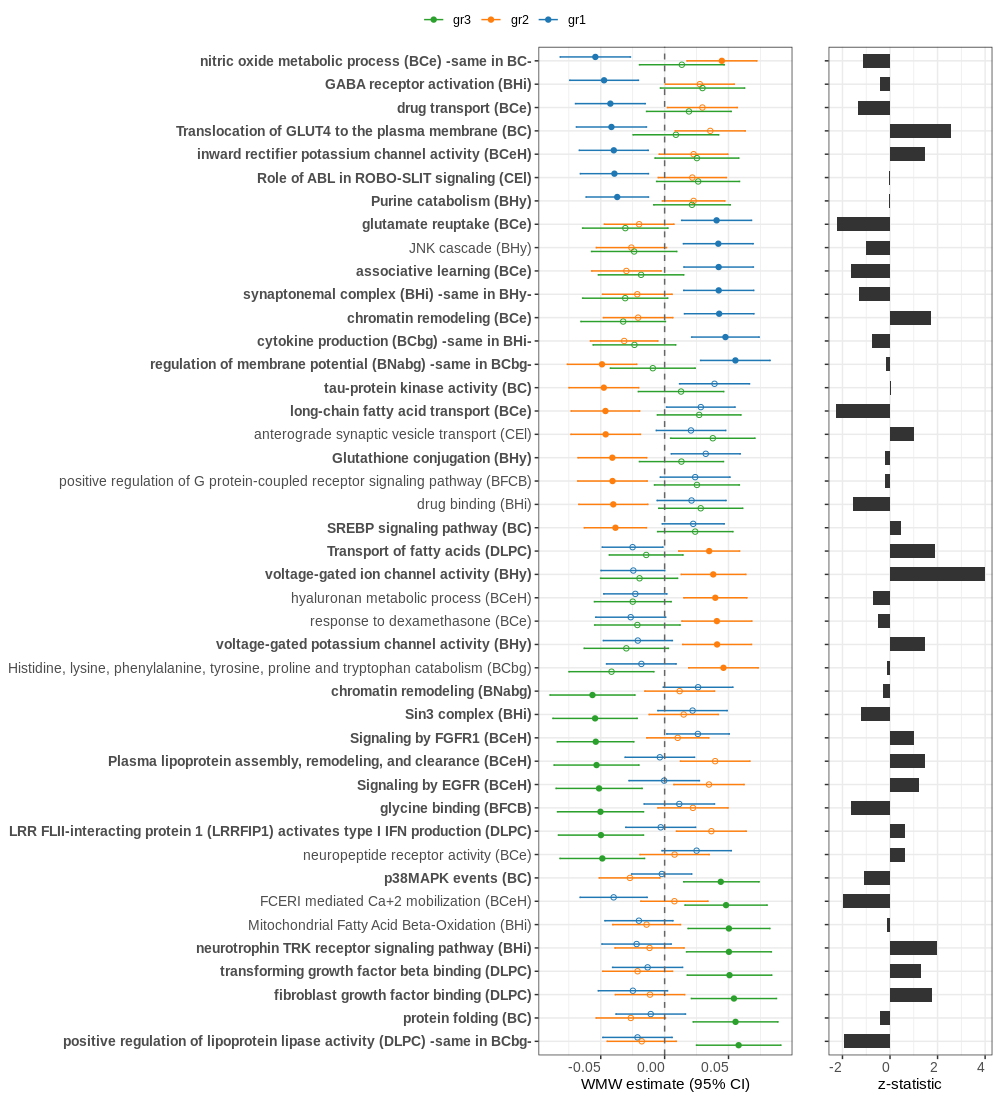

In [137]:
#### forest plot ####

options(repr.plot.width = 10, repr.plot.height = 11, repr.plot.res = 100)

df_est <- path_feat_noMHC
df_est$new_id <- factor(df_est$new_id, levels = rev(id))
df_est$sign <- 'no'
df_est$sign[df_est$pval_corr <= 0.05] <- 'yes'
df_est$sign <- factor(df_est$sign, levels = c('no', 'yes'))
df_est$gr <- unname(sapply(df_est$comp, function(x) strsplit(x, split = '_vs_all')[[1]]))
df_est$gr <- factor(df_est$gr, levels = rev(gr))
face_path <- rep('plain', length(id))
face_path[path_info_noMHC$impr] <- 'bold'

pl_est <-  ggplot(df_est,  
                  aes(x = new_id, y = estimates, group = gr, color = gr, shape = sign))+
  geom_point(position=position_dodge(0.5))+geom_errorbar(aes(ymin=CI_low, ymax=CI_up), 
                                                         width=.2, position=position_dodge(0.5))+
  theme_bw()+ 
  ylab('WMW estimate (95% CI)')+
  geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
  theme(legend.position = 'right', legend.title = element_blank(), legend.text = element_text(size = 9), 
        plot.title = element_text(size=9), axis.title.y = element_blank(),  axis.title.x = element_text(size = 11),
        axis.text.x = element_text(size = 10, angle = 0, hjust = 1), axis.text.y = element_text(size = 10, face = rev(face_path)),
        strip.text = element_text(size=9))+
  scale_shape_manual(values=c(1, 19))+
  scale_color_manual(values=rev(colors_gr))+guides(shape=FALSE)+
  coord_flip()

# plot significnace
df_pval <- path_info_noMHC[, c('new_id', 'Zstat')]
df_pval$new_id <- factor(df_pval$new_id, levels = rev(id))
path_zstat_pl <- ggplot(df_pval, aes(x=new_id, y=Zstat))+
  geom_bar(stat = "identity", fill = 'grey20', width = 0.6)+
  theme_bw()+ylab('z-statistic')+ xlab("")+
  theme(strip.text = element_text(size = 9),
        axis.text.y=element_blank(),  axis.text.x = element_text(size = 10, angle = 0, hjust = 1)) +
  coord_flip()

tot_pl <- ggarrange(plotlist = list(pl_est, path_zstat_pl), ncol = 2, nrow = 1, align='h',widths = c(1, 0.25), common.legend = T)
# save
write.table(x = df_est, file = sprintf('%sforestPlot_cl%s_pathWMWEst_tscoreClusterCases.txt', fold_out, tissue_name), col.names =  T, row.names = F, sep = '\t', quote = F)
ggsave(filename = sprintf('%sforestPlot_cl%s_pathWMWEst_tscoreClusterCases.png', fold_out, tissue_name), width = 10, height = 11, plot = tot_pl, device = 'png')
ggsave(filename = sprintf('%sforestPlot_cl%s_pathWMWEst_tscoreClusterCases.pdf', fold_out, tissue_name), width = 10, height = 11, plot = tot_pl, device = 'pdf')
# print
tot_pl


In [12]:
#################################################
###### endophenotype differences selection ######
#################################################

pheno_name <- 'SCZ'
color_pheno_file <- 'UKBB/eQTL_PROJECT/INPUT_DATA/Covariates/color_pheno_type_UKBB_v2.txt'
riskScore_ann_file <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/SCZ_clustering/matchUKBB_updated_riskScores_tscore_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_metaAnalysis_annotated.txt'
phenoInfo_file <- 'SCZ_PGC/eQTL_PROJECT/phenotypeDescription_rsSCZ_updated.txt'
pheno_plot <- 'SCZ_PGC/eQTL_PROJECT/Meta_Analysis_SCZ/DLPC_CMC/SCZ_clustering/list_phenoid_plot'
measureGoodness_thr <- 1500

pheno_ann <- fread(color_pheno_file, header = T, stringsAsFactors = F, data.table = F)
phenoInfo <- fread(phenoInfo_file, header = T, stringsAsFactors = F, sep = '\t', data.table = F)
if(!'pheno_type' %in% colnames(phenoInfo)){
  tmp_name <- sapply(phenoInfo$Path, function(x) strsplit(x, split = '> ')[[1]][length(strsplit(x, split = '> ')[[1]])])
  tmp_name <- sapply(tmp_name, function(x) paste0(strsplit(x, split = ' ')[[1]], collapse = '_'))
  phenoInfo$pheno_type <- tmp_name
  phenoInfo$pheno_type[phenoInfo$pheno_type == 'Summary_Information_(diagnoses)'] <- 'ICD9-10_OPCS4'
}

rs_res <- fread(riskScore_ann_file, h=T, stringsAsFactors = F, sep = '\t', data.table = F)
rs_res <- rs_res[!is.na(rs_res$pvalue), ]
head(rs_res[order(rs_res$measure, decreasing = T),])

,pheno_id,Field,meaning,beta,se_beta,z,pvalue,Cochran_stat,Cochran_pval,model,OR_or_Beta,CI_low,CI_up,type_pheno,comp,pval_corr,R2_risk,Fstat_risk,measure,pheno_type
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2015,30000,White blood cell (leukocyte) count,NA,-0.8387640,0.01566217,-53.55348,0.000000e+00,26.64324,0.8115327,fixed,-0.8387640,-0.8694613,-0.8080667,CONTINUOUS,gr3_vs_all,0.000000e+00,0.04247765,14719.59,12346.264,Blood_count
2027,30120,Lymphocyte count,NA,-0.8340990,0.01566442,-53.24801,0.000000e+00,26.99352,0.7978038,fixed,-0.8340990,-0.8648007,-0.8033973,CONTINUOUS,gr3_vs_all,0.000000e+00,0.04158747,14533.55,12122.423,Blood_count
2028,30130,Monocyte count,NA,-0.6357227,0.01610848,-39.46509,0.000000e+00,36.28719,0.3624598,fixed,-0.6357227,-0.6672947,-0.6041506,CONTINUOUS,gr3_vs_all,0.000000e+00,0.04078011,15013.88,9544.666,Blood_count
2047,PLR,Platelet-to-Lymphocyte ratio,NA,0.5437294,0.01625963,33.44046,3.542047e-245,36.18074,0.3671022,fixed,0.5437294,0.5118611,0.5755977,CONTINUOUS,gr3_vs_all,3.935608e-243,0.04891806,17118.15,9307.644,Blood_count_ratio
2851,30860,Total protein,NA,-0.7972047,0.01577853,-50.52465,0.000000e+00,32.38831,0.5467063,fixed,-0.7972047,-0.8281300,-0.7662793,CONTINUOUS,gr3_vs_all,0.000000e+00,0.03742234,11619.95,9263.481,Blood_biochemistry
2029,30140,Neutrophill count,NA,-0.6422333,0.01608854,-39.91867,0.000000e+00,24.50936,0.8842952,fixed,-0.6422333,-0.6737663,-0.6107004,CONTINUOUS,gr3_vs_all,0.000000e+00,0.04101795,14161.43,9094.940,Blood_count


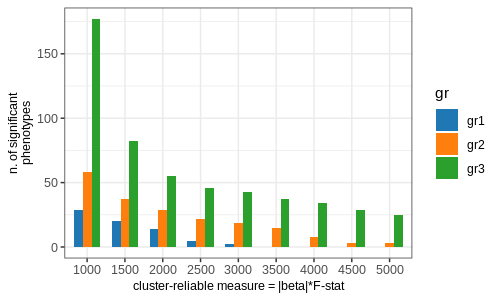

In [13]:
###################################
### plot number of association ####
###################################

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 100)

rs_res$comp <- factor(rs_res$comp)
rs_res$sign <- 'no'
rs_res$sign[rs_res$pval_corr <= 0.05] <- 'yes'

thr_lims <- seq(1000, 5000, by = 500)
df <- list()
for(i in 1:length(thr_lims)){
  df[[i]] <- rs_res %>% filter(measure >=thr_lims[i]) %>% group_by(comp) %>% count(sign, .drop = FALSE) %>% add_column(CRM_thr = thr_lims[i])
}
df <- bind_rows(df)
df <- df %>% mutate(gr = strsplit(as.character(comp), split = '_vs_all')[[1]])
df$gr <- factor(df$gr)
df$CRM_thr <- factor(df$CRM_thr, levels = thr_lims)

pl_count <-  ggplot(df, aes(x = CRM_thr, y = n, fill = gr))+
  geom_bar(stat = 'identity', width = 0.7,
           position=position_dodge())+
  theme_bw()+ 
  ylab('n. of significant\nphenotypes')+ 
  xlab('cluster-reliable measure = |beta|*F-stat')+ 
  theme(legend.position = 'right', axis.title.y = element_text(size = 9), axis.title.x = element_text(size=9),
        axis.text.x = element_text(size = 9), axis.text.y = element_text(size = 9))+
  scale_fill_d3()
ggsave(filename = sprintf('%sriskScores_tscore_zscaled_cluster%s_GLM_count.png', fold_out, 'Cases'), width = 5, height = 3, plot = pl_count, device = 'png', dpi = 300)
ggsave(filename = sprintf('%sriskScores_tscore_zscaled_cluster%s_GLM_count.pdf', fold_out, 'Cases'), width = 5, height = 3, plot = pl_count, device = 'pdf')

pl_count

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


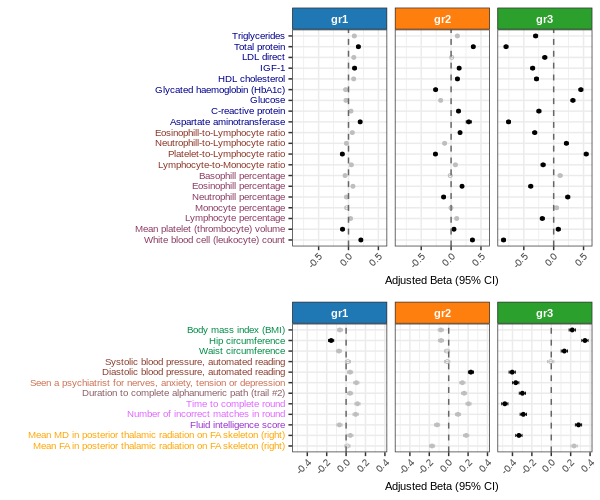

In [16]:
#####################################################
### plot selection of association among 1500 thr ####
#####################################################

options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 100)

pheno_to_plot <- fread(pheno_plot, header = F, stringsAsFactors = F)$V1
rs_tmp <- rs_res[rs_res$pheno_id %in% pheno_to_plot, ]
rs_tmp$new_id <- paste0(rs_tmp$comp, '_and_', rs_tmp$pheno_id)
P <- length(unique(rs_tmp$comp))
gr_color <- pal_d3(palette = 'category20')(P)

df_red <- rs_tmp
df_red$type_m <- 'not reliable'
df_red$type_m[df_red$measure >= measureGoodness_thr] <- 'reliable'
df_red$new_id <- df_red$Field
df_red$new_id[!is.na(df_red$meaning)] <- paste(df_red$meaning[!is.na(df_red$meaning)], df_red$Field[!is.na(df_red$meaning)], sep = '\n')
df_red$comp <- factor(df_red$comp, levels = unique(df_red$comp))
df_red$new_id <- factor(df_red$new_id, levels = unique(df_red$new_id))
df_red$pheno_type <- factor(df_red$pheno_type, levels = unique(df_red$pheno_type))
df_red$type_m <- factor(df_red$type_m, levels = c('not reliable', 'reliable'))
df_red$type_res <- 'beta'
df_red$sign <- 'no'
df_red$sign[df_red$pval_corr <= 0.05] <- 'yes'
df_red$sign <- factor(df_red$sign, levels = c('no', 'yes'))

# divide in 2 part
df_red1 <- subset(df_red, pheno_type %in% c('Blood_count', 'Blood_biochemistry', 'Blood_count_ratio'))
df_red2 <- subset(df_red, !pheno_type %in% c('Blood_count', 'Blood_biochemistry', 'Blood_count_ratio'))
pheno_ann_red1 <- pheno_ann[match(df_red1$pheno_type, pheno_ann$pheno_type), ]
pheno_ann_red2 <- pheno_ann[match(df_red2$pheno_type, pheno_ann$pheno_type), ]

len_w <- length(unique(df_red$comp))
len_h <- length(unique(df_red$pheno_id))

# change labels 
labs_new <- sapply(as.character(unique(df_red$comp)), function(x) strsplit(x, split = '_vs_all')[[1]][1])
names(labs_new) <- as.character(unique(df_red$comp))

pl_beta1 <-  ggplot(df_red1, aes(x = new_id, y = OR_or_Beta, shape = sign, color = type_m))+
  geom_errorbar(aes(ymin=CI_low, ymax=CI_up), size = 0.3, width=.3, position=position_dodge(0.05), show.legend=FALSE, linetype="solid")+
  geom_point(position=position_dodge(0.05), size = 1)+
  theme_bw()+ 
  ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
  facet_wrap(comp~., nrow = 1, strip.position="top",  labeller = labeller(comp = labs_new))+
  theme(legend.position = 'none', plot.title = element_text(size=9), axis.title.y = element_blank(), axis.title.x = element_text(size=8),
        axis.text.x = element_text(size = 7, angle = 45, hjust = 1), axis.text.y = element_text(size = 7,  colour = pheno_ann_red1$color), 
        strip.text = element_text(size=8, color = 'white', face = 'bold'))+
  scale_shape_manual(values=c(1, 19))+
  scale_color_manual(values=c('grey', 'black'))+
  coord_flip()

pl_beta1 <- ggplot_gtable(ggplot_build(pl_beta1))
stripr <- which(grepl('strip-t', pl_beta1$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
  j <- which(grepl('rect', pl_beta1$grobs[[i]]$grobs[[1]]$childrenOrder))
  pl_beta1$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
  k <- k+1
}


pl_beta2 <-  ggplot(df_red2, aes(x = new_id, y = OR_or_Beta, shape = sign, color = type_m))+
  geom_errorbar(aes(ymin=CI_low, ymax=CI_up), size = 0.3, width=.3, position=position_dodge(0.05), show.legend=FALSE, linetype="solid")+
  geom_point(position=position_dodge(0.05), size = 1)+
  theme_bw()+ 
  ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
  facet_wrap(comp~., nrow = 1, strip.position="top",  labeller = labeller(comp = labs_new))+
  theme(legend.position = 'none', plot.title = element_text(size=9), axis.title.y = element_blank(), axis.title.x = element_text(size=8),
        axis.text.x = element_text(size = 7, angle = 45, hjust = 1), axis.text.y = element_text(size = 7,  colour = pheno_ann_red2$color), 
        strip.text = element_text(size=8, color = 'white', face = 'bold'))+
  scale_shape_manual(values=c(1, 19))+
  scale_color_manual(values=c('grey', 'black'))+
  coord_flip()

pl_beta2 <- ggplot_gtable(ggplot_build(pl_beta2))
stripr <- which(grepl('strip-t', pl_beta2$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
  j <- which(grepl('rect', pl_beta2$grobs[[i]]$grobs[[1]]$childrenOrder))
  pl_beta2$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
  k <- k+1
}

tot_pl <- ggarrange(plotlist = list(pl_beta1, pl_beta2), ncol = 1, nrow = 2, align='v', heights = c(1, 0.7))
ggsave(filename = sprintf('%sriskScores_tscore_zscaled_cluster%s_GLM_beta_measureThr%s_selected.png', fold_out, 'Cases', as.character(measureGoodness_thr)), width = len_w+3, height = len_h*0.1+2, plot = tot_pl, device = 'png', dpi=300)
ggsave(filename = sprintf('%sriskScore_tscore_zscaled_cluster%s_GLM_beta_measureThr%s_selected.pdf', fold_out,'Cases', as.character(measureGoodness_thr)), width = len_w+3, height = len_h*0.1+2, plot = tot_pl, device = 'pdf')

tot_pl                   

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


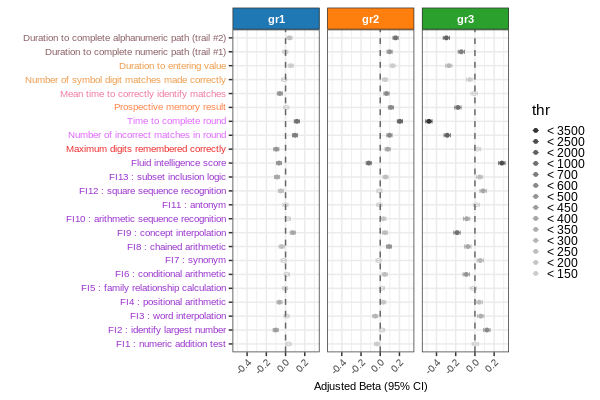

In [21]:
####################################
##### plot cognitive functions #####
####################################
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 100)

id_FI <- as.character(c(486, 4935 ,4946 ,4957, 4968, 4979,4990,5001,5012,5556,5699,5779,5790,5866,20016))
id_PaM <- as.character(c('399', '400'))
id_NM <- as.character(c('20240'))
id_RT <- as.character(c('20023'))
id_PM <- as.character(c('20018'))
id_SDS <- as.character(c('20230', '20159'))
id_TM <- as.character(c('20156', '20157'))

rs_red <- rs_res[rs_res$pheno_id %in% c(id_FI, id_TM, id_SDS, id_PM, id_RT, id_NM, id_PaM), ]
P <- length(unique(rs_red$comp))
df_red <- rs_red
df_red$type_m <- 'not reliable'
df_red$type_m[df_red$measure >= measureGoodness_thr] <- 'reliable'
df_red$new_id <- df_red$Field
df_red$new_id[!is.na(df_red$meaning)] <- paste(df_red$meaning[!is.na(df_red$meaning)], df_red$Field[!is.na(df_red$meaning)], sep = '\n')
df_red$comp <- factor(df_red$comp, levels = unique(df_red$comp))
df_red$new_id <- factor(df_red$new_id, levels = unique(df_red$new_id))
df_red$pheno_type <- factor(df_red$pheno_type, levels = unique(df_red$pheno_type))
df_red$type_m <- factor(df_red$type_m, levels = c('not reliable', 'reliable'))
df_red$type_res <- 'beta'
df_red$sign <- 'no'
df_red$sign[df_red$pval_corr <= 0.05] <- 'yes'
df_red$sign <- factor(df_red$sign, levels = c('no', 'yes'))
thr_lims <- c(150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 1000, 2000, 2500, 3500)
df_red$thr <- paste0('< ', thr_lims[1])
for(i in 1:(length(thr_lims)-1)){
  df_red$thr[df_red$measure > thr_lims[i] & df_red$measure <= thr_lims[i+1]] <- paste0('< ', thr_lims[i+1])
}
thr_lims <- unique(df_red$thr)
thr_lims <- thr_lims[order(as.numeric(sapply(thr_lims, function(x) strsplit(x, split = '< ')[[1]][2])))]
df_red$thr <- factor(df_red$thr, levels = rev(thr_lims))
pheno_ann_red <- pheno_ann[match(df_red$pheno_type, pheno_ann$pheno_type), ]

len_w <- length(unique(df_red$comp))
len_h <- length(unique(df_red$pheno_id))

pl_beta <-  ggplot(df_red, aes(x = new_id, y = OR_or_Beta, shape = sign, color = thr))+
  geom_errorbar(aes(ymin=CI_low, ymax=CI_up), size = 0.3, width=.3, position=position_dodge(0.05), linetype="solid")+
  geom_point(position=position_dodge(0.05), size = 1)+
  theme_bw()+
  ylab('Adjusted Beta (95% CI)')+ geom_hline(yintercept = 0, linetype = 'dashed', color = 'grey40')+
  facet_wrap(comp~., nrow = 1, strip.position="top",  labeller = labeller(comp = labs_new))+
  theme(legend.position = 'right', plot.title = element_text(size=9), axis.title.y = element_blank(), axis.title.x = element_text(size=8),
        legend.key.size = unit(0.2, "cm"),
        axis.text.x = element_text(size = 7, angle = 45, hjust = 1), axis.text.y = element_text(size = 7,  colour = pheno_ann_red$color),
        strip.text = element_text(size=8, color = 'white', face = 'bold'))+
  scale_shape_manual(values=c(1, 19))+
  scale_colour_grey()+
  guides(shape = FALSE)+
  coord_flip()

pl_beta <- ggplot_gtable(ggplot_build(pl_beta))
stripr <- which(grepl('strip-t', pl_beta$layout$name))
fills <- gr_color
k <- 1
for (i in stripr) {
  j <- which(grepl('rect', pl_beta$grobs[[i]]$grobs[[1]]$childrenOrder))
  pl_beta$grobs[[i]]$grobs[[1]]$children[[j]]$gp$fill <- fills[k]
  k <- k+1
}
ggsave(filename = sprintf('%sriskScores_tscore_zscaled_cluster%s_GLM_beta_measureThr%s_CogntiveTests.png', fold_out, 'Cases', as.character(measureGoodness_thr)), width = len_w+3, height = (len_h)*0.1+1, plot = pl_beta, device = 'png', dpi=320)
ggsave(filename = sprintf('%sriskScore_tscore_zscaled_cluster%s_GLM_beta_measureThr%s_CogntiveTests.pdf', fold_out,'Cases', as.character(measureGoodness_thr)), width = len_w+3, height = (len_h)*0.1+1, plot = pl_beta, device = 'pdf')
tot_pl <- ggarrange(plotlist = list(pl_beta), ncol = 1, nrow = 1, align='v')
print(tot_pl)

In [27]:
riskScore_ann_file <- 'SCZ_PGC/eQTL_PROJECT/clustering_res_matchUKBB/DLPC_CMC/matchUKBB_allSamples_riskScores_updated_tscore_zscaled_clusterAll_PGmethod_HKmetric_phenoAssociation_GLMpairwise_metaAnalysis_annotated.txt'
a = fread(riskScore_ann_file)
a[grepl('Waist', a$Field),]

pheno_id,Field,meaning,beta,se_beta,z,pvalue,Cochran_stat,Cochran_pval,model,OR_or_Beta,CI_low,CI_up,type_pheno,comp,pval_corr,R2_risk,Fstat_risk,measure,pheno_type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
48,Waist circumference,NA,-0.09030203,0.01242206,-7.269488,3.608522e-13,41.97026,0.16369152,fixed,-0.09030203,-0.114648829,-0.06595524,CONTINUOUS,gr1_vs_gr0,4.876381e-12,0.0274069,12559.93,1134.1872,Body_size_measures
48,Waist circumference,NA,-0.05651967,0.01236493,-4.570966,4.854816e-06,43.99840,0.11707178,fixed,-0.05651967,-0.080754489,-0.03228485,CONTINUOUS,gr2_vs_gr0,1.178353e-05,0.0274069,12559.93,709.8831,Body_size_measures
48,Waist circumference,NA,0.03480255,0.01491496,2.333398,1.962727e-02,50.05701,0.03730938,fixed,0.03480255,0.005569754,0.06403534,CONTINUOUS,gr2_vs_gr1,3.809583e-02,0.0274069,12559.93,437.1175,Body_size_measures
48,Waist circumference,NA,0.05654478,0.01624700,3.480321,5.008135e-04,25.11546,0.86562556,fixed,0.05654478,0.024701243,0.08838832,CONTINUOUS,gr3_vs_gr0,8.721459e-04,0.0274069,12559.93,710.1985,Body_size_measures
48,Waist circumference,NA,0.14694856,0.01849996,7.943183,1.970585e-15,24.91034,0.87212695,fixed,0.14694856,0.110689306,0.18320782,CONTINUOUS,gr3_vs_gr1,6.119830e-15,0.0274069,12559.93,1845.6635,Body_size_measures
48,Waist circumference,NA,0.11905698,0.01826095,6.519758,7.042069e-11,34.72435,0.43327645,fixed,0.11905698,0.083266178,0.15484779,CONTINUOUS,gr3_vs_gr2,1.530885e-10,0.0274069,12559.93,1495.3473,Body_size_measures
